In [6]:
import pandas as pd 
import numpy as np

# Data Sources
from pandas_datareader import data,wb
from datetime import date

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Start Date means from which date we want to start fetching Stock Data?
# End Date means till which date we want to fetch Stock Data?
startdate = pd.to_datetime('1990-01-01')
enddate = pd.to_datetime(date.today())

stock_data = data.DataReader(['SPY', 'ACWI', 'URTH', 'EFA', 'QQQ', 'ONEQ', 'IWF', 'IWM', 'IWV'], 'stooq', startdate, enddate)
stock_data = stock_data['Close'].dropna()


#### Test Out a Few Benchmarks

The following code will devise some simple benchmark strategies and evaluations of performance as a baseline relative to the more complex models including 1) copulas 2) time series 3) cointegration

#### Testing Copulas

The simplest trading strategy is to use different decision thresholds based on the copula joint p value to either 1) go short the trading pair and long the leg pair when the p value > .5 and vice versa 2) When you reach very large thresholds put on a trade until you converge back to .5.

In [8]:
!pip install copulas

In [9]:
stock_test_data = stock_data[['SPY', 'IWV']]

import copulas
from copulas.multivariate import GaussianMultivariate

def generate_log_returns(stock_test_data, periods = 252):
    ret_df = np.log(stock_test_data) - np.log(stock_test_data.shift(periods))
    return ret_df.dropna()

def generate_copula(sample_df):
    """ 
    Takes in a dataframe with the leg pair in the first column and the tradable pair in the second column
    """
    copula = GaussianMultivariate()
    copula.fit(sample_df)
    dist_cdf = copula.cdf(sample_df)
    return pd.DataFrame({'Copula_Cdf': dist_cdf}, index = sample_df.index)

cdf_df = generate_copula(generate_log_returns(stock_test_data))

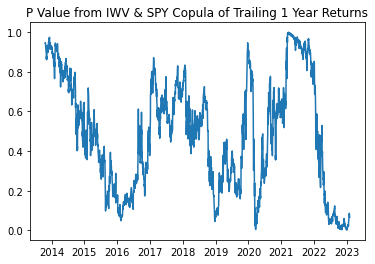

In [14]:
plt.plot(cdf_df)
plt.title("P Value from IWV & SPY Copula of Trailing 1 Year Returns")
plt.show()


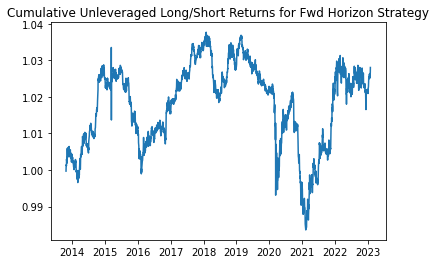

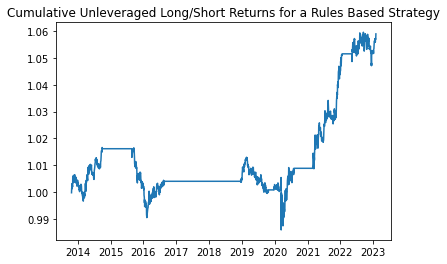

In [15]:
def fwd_horizon_eval(cdf_df, stock_test_data, fwd_horizon, leg_pair, trade_pair, trade_trigger):
    """
    There are two simple strategies illustrated below: 
    - If p > .5, short the trade leg and long the pair leg
    """
    fwd_ret = np.log(stock_test_data.shift(-1*fwd_horizon)) - np.log(stock_test_data)
    fwd_ret['Trade - Leg'] = fwd_ret[trade_pair] - fwd_ret[leg_pair]
    append_df = fwd_ret.join(cdf_df).dropna()
    append_df['Strat_Return'] = np.where(append_df['Copula_Cdf'] > trade_trigger, 1 + -1*append_df['Trade - Leg'], 
                                         np.where(append_df['Copula_Cdf'] < (1-trade_trigger), 1 + append_df['Trade - Leg'], 1))
    append_df['CumulativeRet'] = append_df['Strat_Return'].cumprod()
    append_df = append_df.dropna()
    return append_df

def parametric_copula_strategy(copula_df, trigger):
    copula_list = copula_df['Copula_Cdf'].to_list()
    positions_vector = []
    
    #Initialize the first position
    if copula_list[0] > trigger: 
        positions_vector.append(-1)
    elif copula_list[0] < (1 - trigger):
        positions_vector.append(1)
    else: 
        positions_vector.append(0)
    
    for i in range(1, len(copula_list)):
        if (positions_vector[-1] == -1) & (copula_list[i] > .5):
            positions_vector.append(-1)
        elif (positions_vector[-1] == 0) & (copula_list[i] > trigger):
            positions_vector.append(-1)
        elif (positions_vector[-1] == 1) & (copula_list[i] < .5):
            positions_vector.append(1)
        elif (positions_vector[-1] == 0) & (copula_list[i] < (1-trigger)):
            positions_vector.append(1)
        else:
            positions_vector.append(0)
        
    copula_df['Positioning'] = positions_vector
    copula_df['Parametric_Strat_Ret'] = 1 + copula_df['Trade - Leg'] * copula_df['Positioning']
    copula_df['Cumulative_Parametric']  = copula_df['Parametric_Strat_Ret'].cumprod()
    return copula_df

copula_df = fwd_horizon_eval(cdf_df, stock_test_data, 1, 'SPY', 'IWV', .5)
parametric_df = parametric_copula_strategy(copula_df, .9)

#Plot the returns of the strategy using a fixed forward horizon
plt.plot(copula_df['CumulativeRet'])
plt.title("Cumulative Unleveraged Long/Short Returns for Fwd Horizon Strategy")
plt.show()

#Plot the returns of the strategy using a rules based approach
plt.plot(parametric_df['Cumulative_Parametric'])
plt.title("Cumulative Unleveraged Long/Short Returns for a Rules Based Strategy")
plt.show()

#### Testing the Time Series Models

Similarly we can use time series techniques to forecast the spread based on prior spreads up until this point using both the fixed forward horizon approach.

In [16]:
def Spreads(df: pd.DataFrame(), bm1:str, bm2:str, horizons = [1, 5, 21, 63]) -> pd.DataFrame():
    legs_df = df[[bm1, bm2]]
    spread_df = pd.DataFrame(index = legs_df.index)
    for horizon in horizons:
        iter_chg = legs_df.pct_change(periods = horizon)
        iter_spreads = pd.Series(iter_chg[bm1] - iter_chg[bm2], name = 'Spread_' + str(horizon))
        spread_df = spread_df.join(iter_spreads)
    return spread_df.dropna()

ts_spread_df = Spreads(stock_data, 'SPY', 'IWF', horizons = [1, 5, 21, 63])
ts_spread_df = ts_spread_df.dropna()

from statsmodels.tsa.stattools import adfuller

def AD_full_tests(df:pd.DataFrame()):
    for col in df.columns:
        ad_fuller_result = adfuller(df[col])
        print(f'ADF Statistic: {ad_fuller_result[0]}')
        print(f'p-value: {ad_fuller_result[1]}')
        
AD_full_tests(ts_spread_df)


ADF Statistic: -32.04356661605364
p-value: 0.0
ADF Statistic: -9.127844511428655
p-value: 3.07895862839336e-15
ADF Statistic: -5.801503215569818
p-value: 4.61952890790493e-07
ADF Statistic: -3.888061561907279
p-value: 0.0021244854812105243


In [17]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

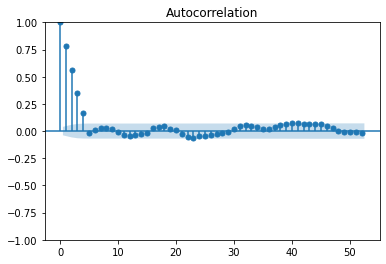

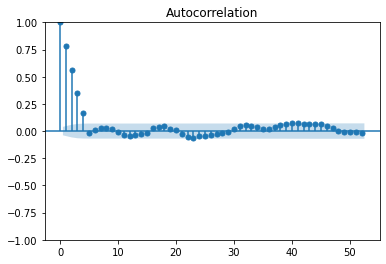

In [25]:
plot_acf(ts_spread_df['Spread_5'], lags=52)

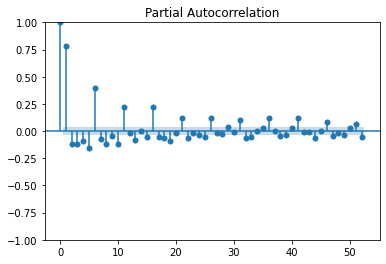

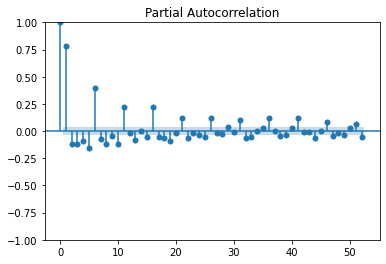

In [26]:
plot_pacf(ts_spread_df['Spread_5'], lags=52)

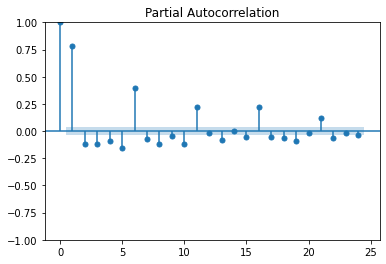

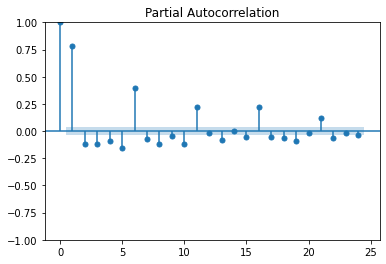

In [31]:
plot_pacf(ts_spread_df['Spread_5'], lags=24)

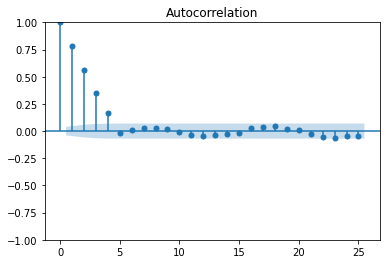

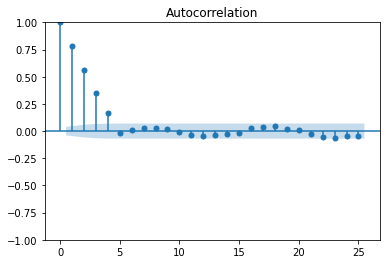

In [207]:
plot_acf(ts_spread_df['Spread_5'], lags=25)

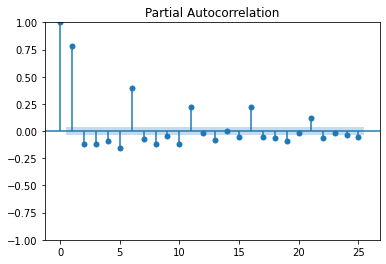

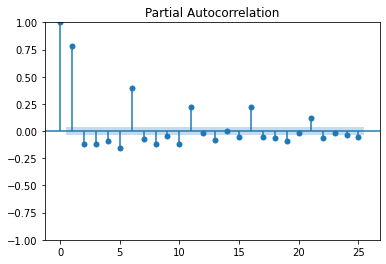

In [206]:
plot_pacf(ts_spread_df['Spread_5'], lags=25)

If any of the above ADF test statistics are insignificant you can't reject the presence of a unit root.

In [208]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

def ARIMA_train(training_end, col, ts_spread_df, freq, criteria = 'aic'):
    ts_spread_df = ts_spread_df.resample(freq).ffill()
    min_date = min(ts_spread_df.index)
    y = ts_spread_df.loc[min_date:training_end, col]
    res = sm.tsa.arma_order_select_ic(y, ic=["aic", "bic"], max_ar=13, max_ma=13, trend="n")
    aic_order = (res.aic_min_order[0], 0, res.aic_min_order[1])
    bic_order = (res.bic_min_order[0], 0, res.bic_min_order[1])
    eval_dict = {'aic': aic_order, 'bic':bic_order}
    model = ARIMA(y, order=eval_dict[criteria])
    model_fit = model.fit()
    return model_fit, eval_dict[criteria]

model, order = ARIMA_train('2015-12-31', 'Spread_5', ts_spread_df, 'W')

C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

In [209]:
def ARMA_predict(training_end, col, ts_spread_df, freq, model, order):
    ts_spread_df = ts_spread_df.resample(freq).ffill()[col]
    predictions = [float(model.forecast(steps=1))]
    training_dates = [x for x in ts_spread_df.index if str(x) > training_end]
    idx_dates = [pd.to_datetime(training_end)] + sorted(list(training_dates))
    for date in training_dates:
        training_df = ts_spread_df[ts_spread_df.index <= date]
        model = ARIMA(training_df, order=order)
        model_fit = model.fit()
        predictions.append(float(model_fit.forecast(steps=1)))

    return pd.Series(predictions, index = idx_dates)

prediction_series = ARMA_predict('2015-12-31', 'Spread_5', ts_spread_df, 'W', model, order)

C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19712\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

Text(0.5, 1.0, 'Out of Sample Spread Predictions')

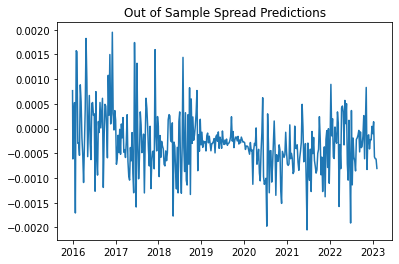

In [213]:
plt.plot(prediction_series.index, prediction_series)
plt.title("Out of Sample Spread Predictions")

In [211]:
bm1 = 'SPY'
bm2 = 'IWV'

def ARMA_strategy(prediction_series, stock_data, bm1, bm2, fwd_horizon):
    prediction_df = pd.DataFrame(prediction_series).resample('D').ffill()
    fwd_spread_df = Spreads(stock_data, bm1, bm2, horizons = [-1*fwd_horizon])
    fwd_spread_df = fwd_spread_df[fwd_spread_df.index >= min(prediction_df.index)]
    fwd_spread_df = fwd_spread_df.join(prediction_df)
    fwd_spread_df.columns = ['Fwd_Ret', 'Prediction']
    fwd_spread_df['Tilt'] = np.where(fwd_spread_df['Prediction'] > 0, 1+fwd_spread_df['Fwd_Ret'], 1+ -1*fwd_spread_df['Fwd_Ret'])
    return fwd_spread_df['Tilt'].cumprod()

cumulative_strategy = ARMA_strategy(prediction_series, stock_data, bm1, bm2, 1)

Text(0.5, 1.0, 'Cumulative Long/Short Pairs Strategy Based on ARMA')

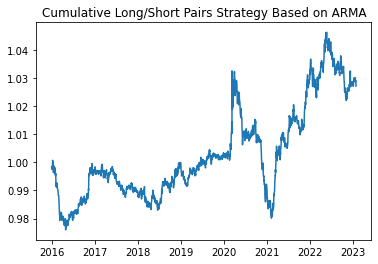

In [214]:
plt.plot(cumulative_strategy)
plt.title("Cumulative Long/Short Pairs Strategy Based on ARMA")

### Establish the VECM Trading Strategy

The work below builds off of Jason's VECM script.  Here I will show a simplified version without the bells and whistles and all the checks for the purpose of illustrating an appropriate trading strategy.

In [91]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
bm1 = 'SPY'
bm2 = 'IWV'

"""
Need to insert an initial parameter search function for determining the lag_order, coint_rank, deterministic, etc

For now let's just make a copy of Jason's parameter dictionary
"""

param_dict = {'lag_order': 5, 'coint_rank': 1, 'deterministic': 'colo'}

def VECM_train(train_df, param_dict):
    vecm = VECM(train_df, 
            k_ar_diff=param_dict['lag_order'], 
            coint_rank=param_dict['coint_rank'],
            deterministic=param_dict['deterministic'])
    vecm_res = vecm.fit()
    return vecm_res 

def VECM_predict(training_end, bm1, bm2, stock_test_data, freq, param_dict, fwd_period = 1):
    stock_test_data = stock_test_data.resample(freq).ffill()[[bm1, bm2]]
    start_date = min(stock_test_data.index)
    prediction_df = pd.DataFrame(columns = [bm1+'_Predict', bm2+'_Predict'])
    training_dates = [str(x) for x in stock_test_data.index if str(x) >= training_end]
    
    for date in training_dates:
        train_df = stock_test_data.loc[start_date:date]
        date_model = VECM_train(train_df, param_dict)
        date_prediction = pd.DataFrame(date_model.predict(steps=1), index = [date], columns = [bm1+'_Predict', bm2+'_Predict'])
        prediction_df = pd.concat([prediction_df, date_prediction])
    return prediction_df

prediction_df = VECM_predict('2015-12-31', 'SPY', 'IWV', stock_test_data, 'D', param_dict)

In [92]:
def VECM_strategy(prediction_df, stock_test_data, fwd_period = 1):
    #Fix date issues of the yahoo download
    stock_test_data.index = pd.to_datetime(stock_test_data.index)
    prediction_df.index = pd.to_datetime(prediction_df.index)
    prediction_df = prediction_df.resample('D').ffill()
    combined_df = stock_test_data.join(prediction_df).dropna()
    
    #Generate inferred returns
    combined_df['Inferred_Ret_SPY'] = combined_df['SPY_Predict']/combined_df['SPY']-1
    combined_df['Inferred_Ret_IWV'] = combined_df['IWV_Predict']/combined_df['IWV']-1
    
    #Generate actual fwd returns
    combined_df['SPY_Fwd'] = combined_df['SPY'].shift(-1*fwd_period)/combined_df['SPY']-1
    combined_df['IWV_Fwd'] = combined_df['IWV'].shift(-1*fwd_period)/combined_df['IWV']-1
    
    #Select the pair with the highest project return next day
    combined_df['Strategy_Ret'] = 1 + np.where(combined_df['Inferred_Ret_SPY'] > combined_df['Inferred_Ret_IWV'], 
                                          combined_df['SPY_Fwd'] - combined_df['IWV_Fwd'], combined_df['IWV_Fwd'] - combined_df['SPY_Fwd'])
    
    return pd.DataFrame(combined_df['Strategy_Ret'].cumprod())
VECM_results = VECM_strategy(prediction_df, stock_test_data)

Text(0.5, 1.0, 'Cumulative Long/Short VECM Trading Strategy')

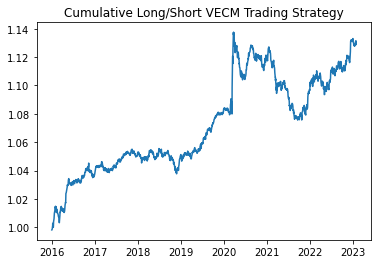

In [93]:
plt.plot(VECM_results)
plt.title("Cumulative Long/Short VECM Trading Strategy")